In [ ]:
!pip install kagglehub

In [ ]:
# Imports
import os
import kagglehub
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf

In [ ]:
# Check GPU
print("✅ TensorFlow version:", tf.__version__)
print("🖥 Available devices:", tf.config.list_physical_devices('GPU'))

✅ TensorFlow version: 2.18.0
🖥 Available devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Download MSTAR dataset
print("📥 Downloading MSTAR dataset from KaggleHub...")
dataset_path = kagglehub.dataset_download("atreyamajumdar/mstar-dataset-8-classes")
print(f"✅ Dataset base path: {dataset_path}")

📥 Downloading MSTAR dataset from KaggleHub...


100%|██████████| 444M/444M [00:03<00:00, 140MB/s]

Extracting files...


✅ Dataset base path: /root/.cache/kagglehub/datasets/atreyamajumdar/mstar-dataset-8-classes/versions/1


In [ ]:
# Dynamically detect correct folder
if "versions" in dataset_path:
    DATASET_PATH = os.path.join(dataset_path, "Padded_imgs")
    if not os.path.exists(DATASET_PATH):
        DATASET_PATH = os.path.join(dataset_path, "versions", "1", "Padded_imgs")
else:
    DATASET_PATH = os.path.join(dataset_path, "versions", "1", "Padded_imgs")

if not os.path.exists(DATASET_PATH):
    raise FileNotFoundError(f"❌ Dataset path does not exist: {DATASET_PATH}")

print(f"✅ Final Dataset Path: {DATASET_PATH}")
print("📁 Classes found:", os.listdir(DATASET_PATH))

✅ Final Dataset Path: /root/.cache/kagglehub/datasets/atreyamajumdar/mstar-dataset-8-classes/versions/1/Padded_imgs
📁 Classes found: ['ZIL131', 'T62', 'ZSU_23_4', 'BRDM_2', 'SLICY', 'D7', '2S1', 'BTR_60']


### Display SAR Image Samples from Each Class

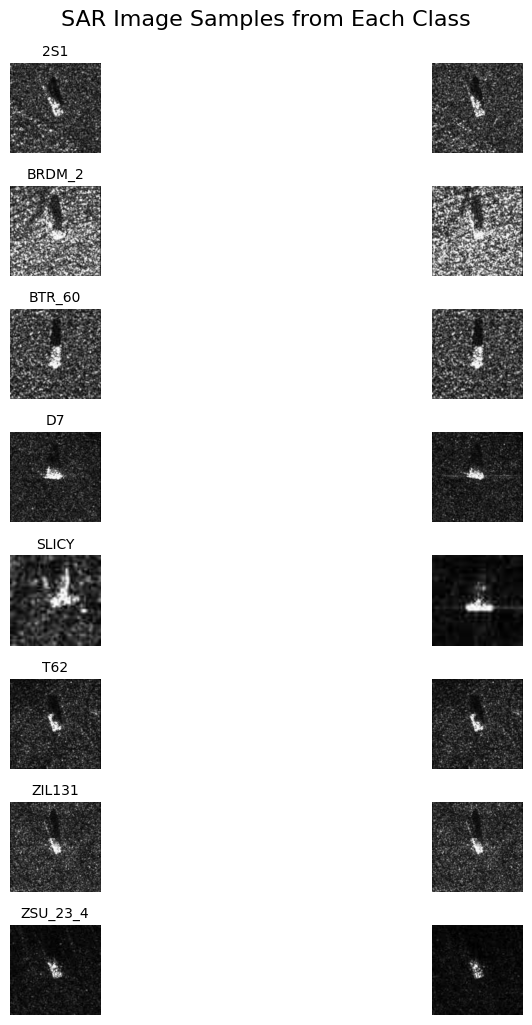

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Parameters
samples_per_class = 2  # how many images per class
figsize = (12, 10)

# Load class names
class_names = sorted(os.listdir(DATASET_PATH))

# Create subplot grid
rows = len(class_names)
cols = samples_per_class

plt.figure(figsize=figsize)
image_count = 1

for i, class_name in enumerate(class_names):
    class_path = os.path.join(DATASET_PATH, class_name)
    image_files = sorted(os.listdir(class_path))[:samples_per_class]

    for j in range(samples_per_class):
        image_path = os.path.join(class_path, image_files[j])
        image = Image.open(image_path)

        plt.subplot(rows, cols, image_count)
        plt.imshow(image, cmap='gray')
        plt.axis('off')
        if j == 0:
            plt.title(class_name, fontsize=10, pad=5)
        image_count += 1

plt.tight_layout()
plt.suptitle("SAR Image Samples from Each Class", fontsize=16, y=1.02)
plt.show()

### Data Preprocessing and Augmentation using ImageDataGenerator
This cell sets up the training and validation data generators with image preprocessing and augmentation settings using Keras' `ImageDataGenerator`.

In [ ]:
IMG_SIZE = (224, 224)            # Resize all images to 224x224 pixels
BATCH_SIZE = 16                  # Number of images per training batch
EPOCHS = 20                      # Total number of training epochs (can be changed)

# Define data augmentation and preprocessing for both training and validation sets
train_datagen = ImageDataGenerator(
    rescale=1./255,             # Normalize pixel values to the range [0, 1]
    validation_split=0.2,       # Reserve 20% of data for validation
    rotation_range=10,          # Randomly rotate images by up to 10 degrees
    zoom_range=0.1,             # Randomly zoom images by up to 10%
    horizontal_flip=True        # Randomly flip images horizontally
)

# Load the training subset of the dataset
train_generator = train_datagen.flow_from_directory(
    DATASET_PATH,               # Path to the dataset directory
    target_size=IMG_SIZE,       # Resize all images to IMG_SIZE
    batch_size=BATCH_SIZE,      # Batch size
    class_mode='categorical',   # Multi-class classification (one-hot encoding)
    subset='training'           # Use the training subset
)

# Load the validation subset of the dataset
val_generator = train_datagen.flow_from_directory(
    DATASET_PATH,               # Same dataset path
    target_size=IMG_SIZE,       # Resize all images to IMG_SIZE
    batch_size=BATCH_SIZE,      # Batch size
    class_mode='categorical',   # Multi-class classification
    subset='validation'         # Use the validation subset
)

Found 7576 images belonging to 8 classes.
Found 1890 images belonging to 8 classes.


### VGG16 Model Construction for SAR Target Classification
This section builds the transfer learning model using a VGG16 convolutional base and custom classification layers. The base is frozen in this initial setup to act as a feature extractor.

In [ ]:
# Load VGG16 base model with pretrained ImageNet weights, excluding the top classification layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all pretrained layers of VGG16 for feature extraction
base_model.trainable = False

# Build the full model using a Sequential API
model = models.Sequential([
    base_model,                            # VGG16 convolutional base (pretrained on ImageNet)
    layers.Flatten(),                      # Flatten the output feature maps
    layers.Dense(256, activation='relu'),  # Add a fully connected (dense) layer with ReLU activation
    layers.Dropout(0.5),                   # Dropout layer with 50% rate to prevent overfitting
    layers.Dense(train_generator.num_classes, activation='softmax')  # Output layer with softmax for multi-class classification
])

# Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),  # Use Adam optimizer with a low learning rate
    loss='categorical_crossentropy',                  # Use categorical cross-entropy loss for multi-class classification
    metrics=['accuracy']                              # Track model accuracy during training and evaluation
)

# Display the model architecture
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,139,528 (80.64 MB)

 Trainable params: 6,424,840 (24.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Train the model using the training and validation generators
history = model.fit(
    train_generator,          # Training data generator
    epochs=EPOCHS,            # Number of epochs to train
    validation_data=val_generator  # Validation data generator for evaluating generalization
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
474/474 ━━━━━━━━━━━━━━━━━━━━ 158s 314ms/step - accuracy: 0.5703 - loss: 1.1858 - val_accuracy: 0.8323 - val_loss: 0.4996
Epoch 2/20
474/474 ━━━━━━━━━━━━━━━━━━━━ 129s 271ms/step - accuracy: 0.8162 - loss: 0.5185 - val_accuracy: 0.8921 - val_loss: 0.3456
Epoch 3/20
474/474 ━━━━━━━━━━━━━━━━━━━━ 134s 283ms/step - accuracy: 0.8602 - loss: 0.3859 - val_accuracy: 0.9212 - val_loss: 0.2713
Epoch 4/20
474/474 ━━━━━━━━━━━━━━━━━━━━ 132s 278ms/step - accuracy: 0.8792 - loss: 0.3277 - val_accuracy: 0.8995 - val_loss: 0.2776
Epoch 5/20
474/474 ━━━━━━━━━━━━━━━━━━━━ 128s 269ms/step - accuracy: 0.8931 - loss: 0.2963 - val_accuracy: 0.9402 - val_loss: 0.2118
Epoch 6/20
474/474 ━━━━━━━━━━━━━━━━━━━━ 143s 302ms/step - accuracy: 0.9036 - loss: 0.2627 - val_accuracy: 0.9455 - val_loss: 0.1691
Epoch 7/20
474/474 ━━━━━━━━━━━━━━━━━━━━ 128s 269ms/step - accuracy: 0.9240 - loss: 0.2201 - val_accuracy: 0.9519 - val_loss: 0.1554
Epoch 8/20
474/474 ━━━━━━━━━━━━━━━━━━━━ 129s 273ms/step - accuracy: 0.9297 -

In [ ]:

model.save("/content/vgg16_sar_classifier.h5")
print("✅ Model saved at /content/vgg16_sar_classifier.h5")

✅ Model saved at /content/vgg16_sar_classifier.h5


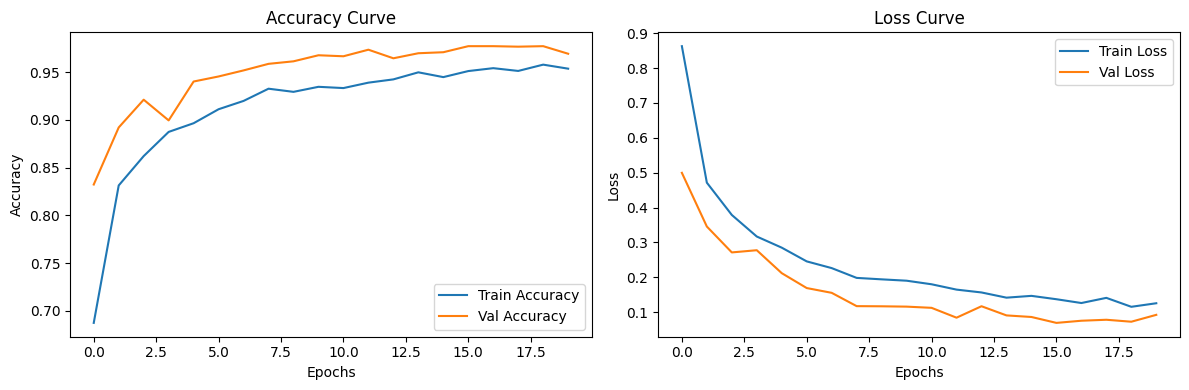

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Accuracy Curve")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.savefig("/content/vgg16_training_curves.png")
plt.show()

119/119 ━━━━━━━━━━━━━━━━━━━━ 27s 214ms/step


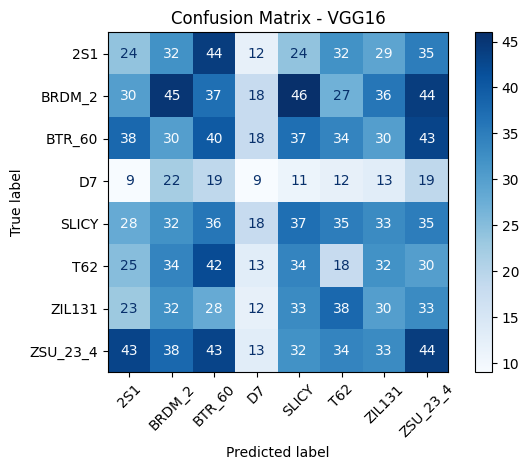

In [ ]:
val_generator.reset()
y_pred_probs = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - VGG16")
plt.tight_layout()
plt.savefig("/content/confusion_matrix_vgg16.png")
plt.show()

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### Data Preprocessing and Image Generator Setup
This section prepares the SAR image dataset for training and validation using `ImageDataGenerator`. It applies normalization and data augmentation techniques (rotation, zoom, flip) and splits the dataset into training (80%) and validation (20%) sets.

In [ ]:
# Define image input size and training parameters
IMG_SIZE = (224, 224)       # Resize all images to 224x224 (required input for VGG16/MobileNetV2)
BATCH_SIZE = 16             # Number of images per batch
EPOCHS = 20                 # Number of training epochs (can be tuned based on results)

# Initialize ImageDataGenerator for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,             # Normalize pixel values to range [0, 1]
    validation_split=0.2,       # Use 20% of data for validation
    rotation_range=10,          # Randomly rotate images by ±10 degrees
    zoom_range=0.1,             # Randomly zoom images by up to 10%
    horizontal_flip=True        # Randomly flip images horizontally
)

# Create data generator for training data
train_generator = train_datagen.flow_from_directory(
    DATASET_PATH,               # Path to the root folder containing subfolders (one per class)
    target_size=IMG_SIZE,       # Resize all images to IMG_SIZE
    batch_size=BATCH_SIZE,      # Number of images per batch
    class_mode='categorical',   # Use one-hot encoding for multi-class labels
    subset='training'           # Load the training subset (80% of total images)
)

# Create data generator for validation data
val_generator = train_datagen.flow_from_directory(
    DATASET_PATH,               # Same dataset path
    target_size=IMG_SIZE,       # Resize images similarly
    batch_size=BATCH_SIZE,      # Same batch size
    class_mode='categorical',   # Categorical labels for validation set
    subset='validation'         # Load the validation subset (20% of total images)
)

Found 7576 images belonging to 8 classes.
Found 1890 images belonging to 8 classes.


###  Model Building - MobileNetV2 Architecture
In this section, we build a lightweight convolutional neural network using MobileNetV2 as the base model. The pretrained layers are frozen initially, and a custom classifier head is added on top for SAR target classification.


In [ ]:
# Load the MobileNetV2 base model (pretrained on ImageNet) without the top classification layers
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all pretrained layers so they are not updated during initial training
base_model.trainable = False  # Freeze base model

# Define the final model with a custom classification head
model_mnv2 = models.Sequential([
    base_model,                                 # MobileNetV2 base model for feature extraction
    layers.GlobalAveragePooling2D(),            # Reduces the spatial dimensions to a single vector per feature map
    layers.Dense(256, activation='relu'),       # Fully connected layer with ReLU activation
    layers.Dropout(0.5),                        # Dropout layer (50%) to reduce overfitting
    layers.Dense(train_generator.num_classes, activation='softmax')  # Final classification layer (softmax output)
])

# Compile the model with Adam optimizer and categorical cross-entropy loss
model_mnv2.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),  # Low learning rate for stable training
    loss='categorical_crossentropy',                  # Suitable for multi-class classification
    metrics=['accuracy']                              # Monitor accuracy metric
)

# Display model architecture summary
model_mnv2.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,587,976 (9.87 MB)

 Trainable params: 329,992 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Train the MobileNetV2 model on the training dataset and validate on the validation dataset
history_mnv2 = model_mnv2.fit(
    train_generator,              # Training data generator
    epochs=EPOCHS,                # Total number of training epochs
    validation_data=val_generator  # Validation data generator for evaluating model performance
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
474/474 ━━━━━━━━━━━━━━━━━━━━ 140s 262ms/step - accuracy: 0.4489 - loss: 1.5926 - val_accuracy: 0.7683 - val_loss: 0.7203
Epoch 2/20
474/474 ━━━━━━━━━━━━━━━━━━━━ 111s 234ms/step - accuracy: 0.7581 - loss: 0.6870 - val_accuracy: 0.8101 - val_loss: 0.5602
Epoch 3/20
474/474 ━━━━━━━━━━━━━━━━━━━━ 131s 277ms/step - accuracy: 0.8049 - loss: 0.5496 - val_accuracy: 0.8418 - val_loss: 0.4570
Epoch 4/20
474/474 ━━━━━━━━━━━━━━━━━━━━ 111s 235ms/step - accuracy: 0.8471 - loss: 0.4327 - val_accuracy: 0.8788 - val_loss: 0.3695
Epoch 5/20
474/474 ━━━━━━━━━━━━━━━━━━━━ 161s 274ms/step - accuracy: 0.8536 - loss: 0.3944 - val_accuracy: 0.8926 - val_loss: 0.3320
Epoch 6/20
474/474 ━━━━━━━━━━━━━━━━━━━━ 111s 234ms/step - accuracy: 0.8613 - loss: 0.3780 - val_accuracy: 0.8836 - val_loss: 0.3290
Epoch 7/20
474/474 ━━━━━━━━━━━━━━━━━━━━ 111s 235ms/step - accuracy: 0.8790 - loss: 0.3365 - val_accuracy: 0.8937 - val_loss: 0.3164
Epoch 8/20
474/474 ━━━━━━━━━━━━━━━━━━━━ 111s 233ms/step - accuracy: 0.8898 -

In [ ]:
model_mnv2.save("/content/mobilenetv2_sar_classifier.h5")
print("✅ Model saved to /content/mobilenetv2_sar_classifier.h5")

✅ Model saved to /content/mobilenetv2_sar_classifier.h5


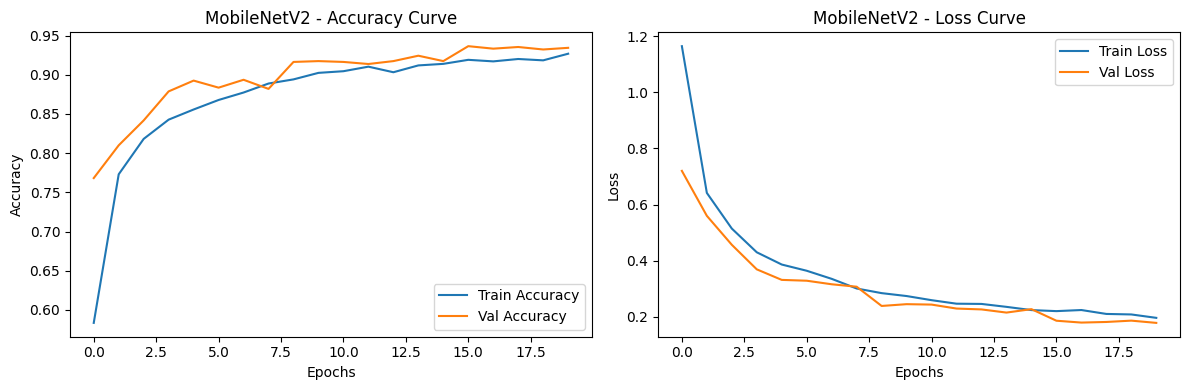

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_mnv2.history['accuracy'], label='Train Accuracy')
plt.plot(history_mnv2.history['val_accuracy'], label='Val Accuracy')
plt.title("MobileNetV2 - Accuracy Curve")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_mnv2.history['loss'], label='Train Loss')
plt.plot(history_mnv2.history['val_loss'], label='Val Loss')
plt.title("MobileNetV2 - Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.savefig("/content/mobilenetv2_training_curves.png")
plt.show()

119/119 ━━━━━━━━━━━━━━━━━━━━ 28s 209ms/step


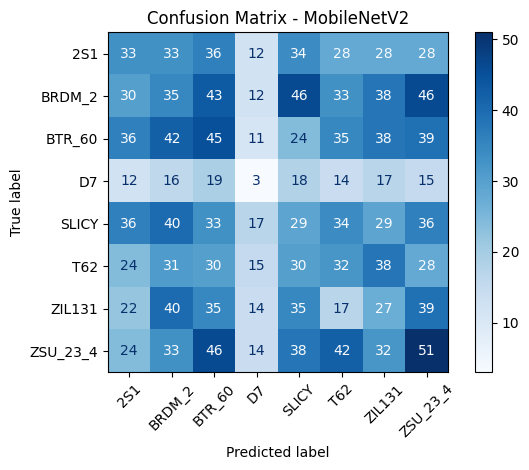

In [ ]:
val_generator.reset()
y_pred_probs = model_mnv2.predict(val_generator)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - MobileNetV2")
plt.tight_layout()
plt.savefig("/content/confusion_matrix_mobilenetv2.png")
plt.show()

### Enhanced Data Augmentation with Regularization Setup (Iteration 2)
This section applies stronger data augmentation strategies to improve model generalization and reduce overfitting. The dataset is split into training and validation sets using `ImageDataGenerator` with advanced augmentation techniques.


In [ ]:
from tensorflow.keras.regularizers import l2  # Import L2 regularization (used in model layers)

# Define image input size, batch size, and total training epochs
IMG_SIZE = (224, 224)       # Resize all images to 224x224 pixels
BATCH_SIZE = 16             # Number of images per batch
EPOCHS = 30                 # Train for more epochs (with early stopping applied later)

# Create an ImageDataGenerator with enhanced augmentation for training and validation data
train_datagen = ImageDataGenerator(
    rescale=1./255,                # Normalize pixel values to [0, 1]
    validation_split=0.2,          # Reserve 20% of data for validation
    rotation_range=25,             # Random rotations up to ±25 degrees
    width_shift_range=0.2,         # Random horizontal shift up to 20% of image width
    height_shift_range=0.2,        # Random vertical shift up to 20% of image height
    brightness_range=[0.8, 1.2],   # Random brightness variation between 80% and 120%
    shear_range=0.1,               # Apply random shearing transformation
    zoom_range=0.2,                # Random zoom up to ±20%
    horizontal_flip=True,          # Randomly flip images horizontally
    fill_mode='nearest'            # Fill in new pixels after augmentation using nearest neighbors
)

# Load training subset of the dataset
train_generator = train_datagen.flow_from_directory(
    DATASET_PATH,                 # Path to dataset directory (with class subfolders)
    target_size=IMG_SIZE,         # Resize all images to IMG_SIZE
    batch_size=BATCH_SIZE,        # Number of images per batch
    class_mode='categorical',     # Use one-hot encoded labels
    subset='training'             # Load training subset (80%)
)

# Load validation subset of the dataset
val_generator = train_datagen.flow_from_directory(
    DATASET_PATH,                 # Same dataset path
    target_size=IMG_SIZE,         # Resize all images to IMG_SIZE
    batch_size=BATCH_SIZE,        # Batch size
    class_mode='categorical',     # Use one-hot encoded labels
    subset='validation'           # Load validation subset (20%)
)

Found 7576 images belonging to 8 classes.
Found 1890 images belonging to 8 classes.


### Fine-Tuned VGG16 Model with L2 Regularization and Dropout
This section implements a fine-tuned VGG16 model by unfreezing the last few convolutional layers. L2 regularization and dropout are added to reduce overfitting and improve generalization.


In [ ]:
# Load the VGG16 base model with pretrained ImageNet weights, excluding top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# ✅ Unfreeze only the last 4 convolutional layers for fine-tuning
for layer in base_model.layers[:-4]:
    layer.trainable = False       # Freeze earlier layers
for layer in base_model.layers[-4:]:
    layer.trainable = True        # Unfreeze last 4 layers to adapt to SAR features

# Build the final model with L2 regularization
model = models.Sequential([
    base_model,                                            # VGG16 convolutional base
    layers.Flatten(),                                      # Flatten feature maps to 1D vector
    layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001)),  # Dense layer with L2 regularization
    layers.Dropout(0.5),                                   # Dropout layer to prevent overfitting
    layers.Dense(train_generator.num_classes, activation='softmax')  # Output layer with softmax activation
])

# Compile the model with a low learning rate for fine-tuning
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),       # Adam optimizer for stability
    loss='categorical_crossentropy',                       # Suitable loss function for multi-class classification
    metrics=['accuracy']                                   # Track accuracy during training
)

# Display model architecture summary
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,139,528 (80.64 MB)

 Trainable params: 13,504,264 (51.51 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

###  Callbacks: Early Stopping and Learning Rate Scheduler
To improve training efficiency and avoid overfitting, we apply two callbacks: EarlyStopping (to halt training if validation loss stagnates) and ReduceLROnPlateau (to reduce the learning rate if the model stops improving).


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Early stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss',             # Monitor validation loss
    patience=5,                     # Stop training if no improvement for 5 consecutive epochs
    restore_best_weights=True,     # Restore model weights from the epoch with the best validation loss
    verbose=1                       # Print a message when early stopping is triggered
)

# Reduce learning rate if validation loss plateaus
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',             # Monitor validation loss
    factor=0.3,                     # Reduce learning rate by a factor of 0.3
    patience=3,                     # Wait 3 epochs before reducing learning rate
    min_lr=1e-6,                    # Set a floor on the learning rate
    verbose=1                       # Print message when learning rate is reduced
)

# Combine both callbacks into a list
callbacks = [early_stop, lr_scheduler]

In [ ]:
# Train the fine-tuned VGG16 model using the training and validation data
history = model.fit(
    train_generator,               # Training data generator
    epochs=EPOCHS,                 # Maximum number of training epochs
    validation_data=val_generator, # Validation data generator
    callbacks=callbacks            # Apply early stopping and learning rate scheduler
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
474/474 ━━━━━━━━━━━━━━━━━━━━ 175s 347ms/step - accuracy: 0.6538 - loss: 1.2155 - val_accuracy: 0.8926 - val_loss: 0.4830 - learning_rate: 1.0000e-04
Epoch 2/30
474/474 ━━━━━━━━━━━━━━━━━━━━ 163s 344ms/step - accuracy: 0.8959 - loss: 0.4668 - val_accuracy: 0.9392 - val_loss: 0.3292 - learning_rate: 1.0000e-04
Epoch 3/30
474/474 ━━━━━━━━━━━━━━━━━━━━ 151s 319ms/step - accuracy: 0.9312 - loss: 0.3358 - val_accuracy: 0.9651 - val_loss: 0.2272 - learning_rate: 1.0000e-04
Epoch 4/30
474/474 ━━━━━━━━━━━━━━━━━━━━ 153s 323ms/step - accuracy: 0.9492 - loss: 0.2739 - val_accuracy: 0.9735 - val_loss: 0.1849 - learning_rate: 1.0000e-04
Epoch 5/30
474/474 ━━━━━━━━━━━━━━━━━━━━ 200s 319ms/step - accuracy: 0.9586 - loss: 0.2202 - val_accuracy: 0.9243 - val_loss: 0.3543 - learning_rate: 1.0000e-04
Epoch 6/30
474/474 ━━━━━━━━━━━━━━━━━━━━ 164s 345ms/step - accuracy: 0.9641 - loss: 0.1983 - val_accuracy: 0.9508 - val_loss: 0.2580 - learning_rate: 1.0000e-04
Epoch 7/30
474/474 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
model.save("/content/vgg16_iteration2_model.h5")
print("✅ Model saved as vgg16_iteration2_model.h5")

✅ Model saved as vgg16_iteration2_model.h5


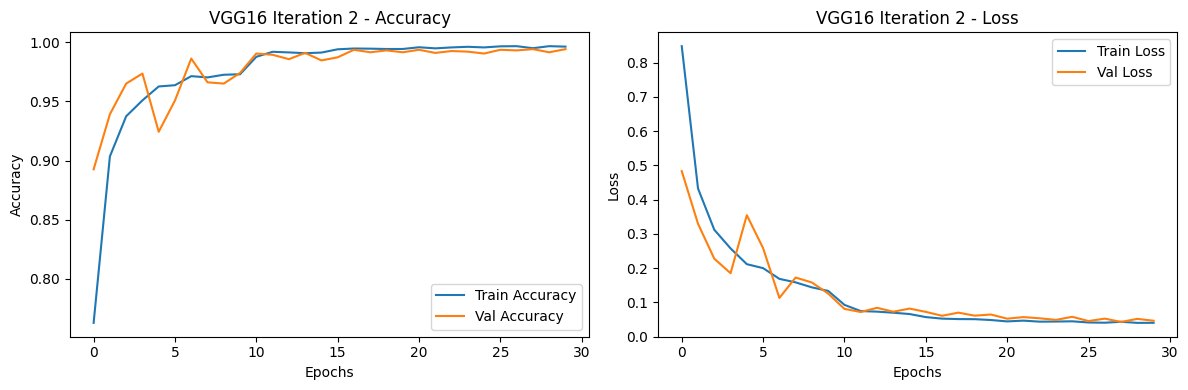

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("VGG16 Iteration 2 - Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("VGG16 Iteration 2 - Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.savefig("/content/vgg16_iteration2_curves.png")
plt.show()

119/119 ━━━━━━━━━━━━━━━━━━━━ 32s 260ms/step


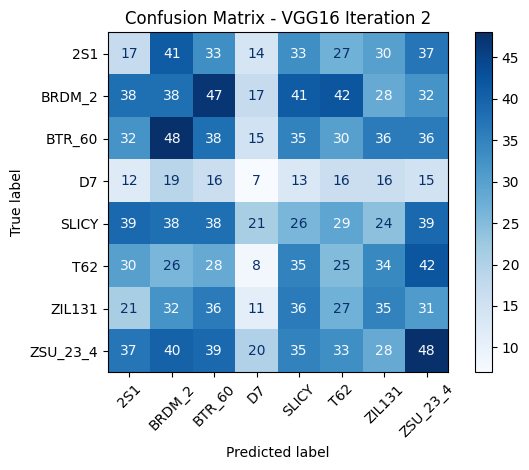

In [ ]:
val_generator.reset()
y_pred_probs = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - VGG16 Iteration 2")
plt.tight_layout()
plt.savefig("/content/confusion_matrix_vgg16_iter2.png")
plt.show()

###  Enhanced Data Preprocessing and Generator Setup (Iteration 2)
This section redefines the training and validation data generators with stronger data augmentation techniques to improve generalization. These settings will be used in the second iteration of model training.

In [ ]:
from tensorflow.keras.regularizers import l2  # Import L2 regularization (used later in model layers)

# Define image preprocessing and training parameters
IMG_SIZE = (224, 224)         # Resize images to 224x224 pixels
BATCH_SIZE = 16               # Number of images processed per training batch
EPOCHS = 30                   # Increase training epochs for iteration 2

# Enhanced data augmentation setup using ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,                # Normalize pixel values to [0, 1]
    validation_split=0.2,          # 20% of the data used for validation
    rotation_range=25,             # Rotate images randomly within ±25 degrees
    width_shift_range=0.2,         # Shift image horizontally by up to 20%
    height_shift_range=0.2,        # Shift image vertically by up to 20%
    brightness_range=[0.8, 1.2],   # Random brightness adjustment between 80% and 120%
    shear_range=0.1,               # Apply shear transformation
    zoom_range=0.2,                # Zoom images randomly within ±20%
    horizontal_flip=True,          # Random horizontal flipping
    fill_mode='nearest'            # Fill empty pixels after transformation using nearest values
)

# Load training subset from the directory structure
train_generator = train_datagen.flow_from_directory(
    DATASET_PATH,                 # Path to dataset (folder with subfolders per class)
    target_size=IMG_SIZE,         # Resize images to match CNN input size
    batch_size=BATCH_SIZE,        # Number of samples per batch
    class_mode='categorical',     # One-hot encoded labels for multi-class classification
    subset='training'             # Load 80% training data
)

# Load validation subset from the same directory structure
val_generator = train_datagen.flow_from_directory(
    DATASET_PATH,                 # Same dataset path
    target_size=IMG_SIZE,         # Same resize settings
    batch_size=BATCH_SIZE,        # Same batch size
    class_mode='categorical',     # Same class mode
    subset='validation'           # Load 20% validation data
)

Found 7576 images belonging to 8 classes.
Found 1890 images belonging to 8 classes.


### Fine-Tuned MobileNetV2 Model with Regularization and Dropout (Iteration 2)
In this step, we fine-tune the MobileNetV2 architecture by unfreezing the last 20 layers. Regularization techniques (L2 and dropout) are applied to improve generalization and reduce overfitting.


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import models, layers, optimizers

# Load MobileNetV2 base model (pretrained on ImageNet) excluding top classifier layers
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# ✅ Unfreeze last 20 layers for fine-tuning; freeze earlier layers
for layer in base_model.layers[:-20]:
    layer.trainable = False       # Freeze earlier layers
for layer in base_model.layers[-20:]:
    layer.trainable = True        # Fine-tune last 20 layers for SAR-specific features

# Build the enhanced MobileNetV2 model with L2 regularization and Dropout
model_mnv2 = models.Sequential([
    base_model,                                             # MobileNetV2 base as feature extractor
    layers.GlobalAveragePooling2D(),                        # Pooling to reduce spatial dimensions
    layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001)),  # Dense layer with L2 regularization
    layers.Dropout(0.5),                                    # Dropout layer to prevent overfitting
    layers.Dense(train_generator.num_classes, activation='softmax')     # Final softmax classifier layer
])

# Compile the model with Adam optimizer and appropriate loss function
model_mnv2.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),        # Low learning rate for stable fine-tuning
    loss='categorical_crossentropy',                        # Loss function for multi-class classification
    metrics=['accuracy']                                    # Monitor accuracy during training
)

# Display model architecture summary
model_mnv2.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,587,976 (9.87 MB)

 Trainable params: 1,536,072 (5.86 MB)

 Non-trainable params: 1,051,904 (4.01 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define early stopping to prevent overfitting by stopping training if validation loss doesn't improve
early_stop = EarlyStopping(
    monitor='val_loss',             # Monitor validation loss
    patience=5,                     # Wait 5 epochs before stopping if no improvement
    restore_best_weights=True,     # Restore model weights from the epoch with the best validation loss
    verbose=1                       # Print a message when early stopping is triggered
)

# Define learning rate scheduler to reduce learning rate when validation loss plateaus
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',             # Monitor validation loss
    factor=0.3,                     # Reduce learning rate by a factor of 0.3
    patience=3,                     # Wait 3 epochs with no improvement before reducing learning rate
    min_lr=1e-6,                    # Set the minimum learning rate
    verbose=1                       # Print a message when learning rate is reduced
)

# Combine both callbacks into a list
callbacks = [early_stop, lr_scheduler]

In [ ]:
# Train the fine-tuned MobileNetV2 model with enhanced data and callbacks
history_mnv2 = model_mnv2.fit(
    train_generator,               # Training data generator
    epochs=EPOCHS,                 # Maximum number of training epochs
    validation_data=val_generator, # Validation data generator
    callbacks=callbacks            # Apply early stopping and learning rate scheduler
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
474/474 ━━━━━━━━━━━━━━━━━━━━ 602s 1s/step - accuracy: 0.6412 - loss: 1.4200 - val_accuracy: 0.7429 - val_loss: 1.1382 - learning_rate: 1.0000e-04
Epoch 2/30
474/474 ━━━━━━━━━━━━━━━━━━━━ 603s 1s/step - accuracy: 0.8834 - loss: 0.7107 - val_accuracy: 0.8317 - val_loss: 0.9518 - learning_rate: 1.0000e-04
Epoch 3/30
474/474 ━━━━━━━━━━━━━━━━━━━━ 581s 1s/step - accuracy: 0.9078 - loss: 0.6233 - val_accuracy: 0.9291 - val_loss: 0.5576 - learning_rate: 1.0000e-04
Epoch 4/30
474/474 ━━━━━━━━━━━━━━━━━━━━ 606s 1s/step - accuracy: 0.9322 - loss: 0.5522 - val_accuracy: 0.9513 - val_loss: 0.4784 - learning_rate: 1.0000e-04
Epoch 5/30
474/474 ━━━━━━━━━━━━━━━━━━━━ 560s 1s/step - accuracy: 0.9463 - loss: 0.4960 - val_accuracy: 0.8958 - val_loss: 0.6330 - learning_rate: 1.0000e-04
Epoch 6/30
474/474 ━━━━━━━━━━━━━━━━━━━━ 565s 1s/step - accuracy: 0.9457 - loss: 0.4603 - val_accuracy: 0.9593 - val_loss: 0.4161 - learning_rate: 1.0000e-04
Epoch 7/30
474/474 ━━━━━━━━━━━━━━━━━━━━ 599s 1s/step - acc

In [ ]:
model_mnv2.save("/content/mobilenetv2_iteration2_model.h5")
print("✅ Model saved as mobilenetv2_iteration2_model.h5")

✅ Model saved as mobilenetv2_iteration2_model.h5


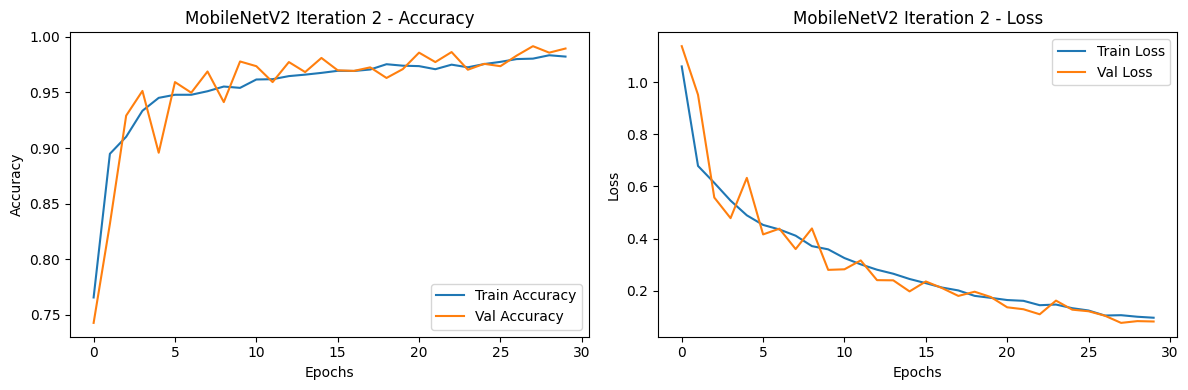

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_mnv2.history['accuracy'], label='Train Accuracy')
plt.plot(history_mnv2.history['val_accuracy'], label='Val Accuracy')
plt.title("MobileNetV2 Iteration 2 - Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_mnv2.history['loss'], label='Train Loss')
plt.plot(history_mnv2.history['val_loss'], label='Val Loss')
plt.title("MobileNetV2 Iteration 2 - Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.savefig("/content/mobilenetv2_iteration2_curves.png")
plt.show()

119/119 ━━━━━━━━━━━━━━━━━━━━ 107s 880ms/step


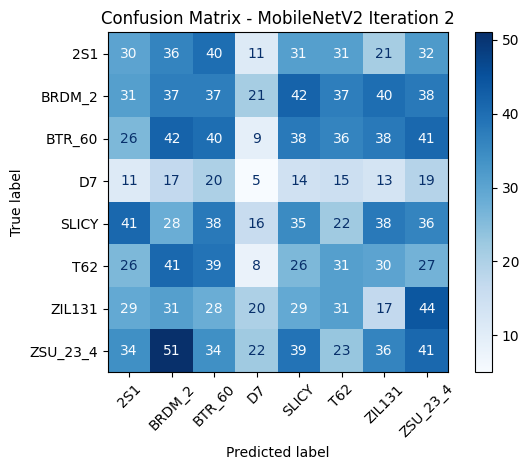

In [ ]:
val_generator.reset()
y_pred_probs = model_mnv2.predict(val_generator)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - MobileNetV2 Iteration 2")
plt.tight_layout()
plt.savefig("/content/confusion_matrix_mobilenetv2_iter2.png")
plt.show()